In [1]:
import pandas as pd
import numpy as np
import os
import csv
import pdb

In [2]:
type_of_interest_source = 'Condition'
type_of_interest_target = 'Term'

def indexing(type_of_interest):

    entity2id  = {}
    id2entity  = {}
    cid2entity = {}

    cid = 0
    with open("./train/entities.tsv", newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['id','entity'])
        for row_val in reader:
            type = row_val['entity'].split('::')[0]
            if type != type_of_interest:
                continue
        
            id = row_val['id']
            entity = row_val['entity']

            entity2id[entity] = int(id)
            id2entity[int(id)] = entity
            cid2entity[cid] = entity
            cid += 1

    print("Number of entities in the type: {}".format(len(entity2id)))
    return entity2id, id2entity, cid2entity

entity2id_s, id2entity_s, cid2entity_s = indexing(type_of_interest_source)
entity2id_t, id2entity_t, cid2entity_t = indexing(type_of_interest_target)

Number of entities in the type: 1394
Number of entities in the type: 2548


In [3]:
def get_entity_name_mapping(type_of_interest):
    
    attribute_file = '/fs/ess/PAS1440/ziqichen/AACT/build_graph/attributes/' + type_of_interest.lower()+'_attribute.txt'
    entity2name = {}
    
    with open(attribute_file, 'r') as f:
        for line in f.readlines():
            idx, _, name = line.rstrip('\n').split(',', 2)
            idx = idx.replace(':', '::').replace('ID', '')
            entity2name[idx] = name
    
    return entity2name

In [4]:
entity2name_s = get_entity_name_mapping(type_of_interest_source) if type_of_interest_source != 'Study' else None
entity2name_t = get_entity_name_mapping(type_of_interest_target) if type_of_interest_target != 'Study' else None

In [5]:
entity_emb = np.load('./ckpts/results_in_paper/CTKG_TransE_l2_entity.npy')

idx_s = np.asarray(list(id2entity_s.keys()), dtype=int)
entity_emb_s = entity_emb[idx_s]

idx_t = np.asarray(list(id2entity_t.keys()), dtype=int)
entity_emb_t = entity_emb[idx_t]

print(entity_emb_s.shape)
print(entity_emb_t.shape)

(1394, 200)
(2548, 200)


In [6]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(entity_emb_s, entity_emb_t)
# cleanup self-compare and dup-compare
s = similarity < 0.99
s = np.unique(similarity[s])

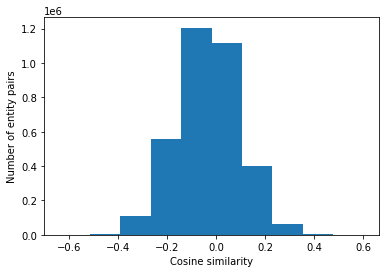

In [7]:
import matplotlib.pyplot as plt
plt.xlabel('Cosine similarity')
plt.ylabel('Number of entity pairs')
plt.hist(s)
plt.show()

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(entity_emb_s, entity_emb_t)
print(similarity.shape)
idx = np.flip(np.argsort(similarity), axis=1)

max_pairs = []
for i in range(idx.shape[0]):
    j = 1
    while (similarity[i][idx[i][j]] > 0.5):
        if type_of_interest_source == 'Study':
            max_pairs.append((cid2entity_s[idx[i][0]], entity2name_t[cid2entity_t[idx[i][j]]], similarity[i][idx[i][j]]))
        else:
            max_pairs.append((entity2name_s[cid2entity_s[i]], entity2name_t[cid2entity_t[idx[i][j]]], similarity[i][idx[i][j]]))
        j += 1

def sort_score(pair):
    return pair[2]

max_pairs.sort(reverse=True, key=sort_score)
sim_pairs = []
for i, pair in enumerate(max_pairs):
    if i % 2 == 0:
        sim_pairs.append(pair)

sim_pairs[:20]

(1394, 2548)


[('"Diabetes Mellitus, Type 2"', '"Benzoates"', 0.5967956),
 ('"Diabetes Mellitus, Type 2"', '"Pulmonary Surfactants"', 0.58667976),
 ('"Diabetes Mellitus, Type 2"', '"Nifurtimox"', 0.57945114),
 ('"Diabetes Mellitus"', '"Pulmonary Surfactants"', 0.5758686),
 ('"Lung Neoplasms"', '"Triterpenes"', 0.57446486),
 ('"Diabetes Mellitus, Type 2"', '"nktr-118"', 0.5682122),
 ('"Squamous Cell Carcinoma of Head and Neck"', '"Naloxone"', 0.56497306),
 ('"Lung Neoplasms"', '"Uric Acid"', 0.5638655),
 ('"Diabetes Mellitus"', '"nktr-118"', 0.56346107),
 ('"Lung Neoplasms"', '"Pregnenediones"', 0.56164813),
 ('"Diabetes Mellitus, Type 2"', '"florbetapir"', 0.5598538),
 ('"Carcinoma"', '"Pregnenediones"', 0.558044),
 ('"Carcinoma"', '"Minerals"', 0.55615157),
 ('"Carcinoma, Non-Small-Cell Lung"', '"Pregnenediones"', 0.5539755),
 ('"Diabetes Mellitus"', '"florbetapir"', 0.5521817),
 ('"Squamous Cell Carcinoma of Head and Neck"', '"ziprasidone"', 0.55130315),
 ('"Squamous Cell Carcinoma of Head and Nec

In [9]:
#sim_pairs[20:40]

In [10]:
#sim_pairs[40:60]

In [11]:
#max_pairs[:10]

In [12]:
similarity.mean()

-0.032962196

In [13]:
#max_pairs[1]

In [14]:
#max_pairs[1][0]

In [15]:
#for i, pair in enumerate(max_pairs):
#    if pair[0] == 'Study::NCT00782210' and pair[2] > 0.7:
#        print(pair)